<a href="https://colab.research.google.com/github/Korniev/Machine-Learning-projects/blob/main/Image_Classification/augm_image_classification_tiny_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.applications import ResNet50, EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
import zipfile
import os
import shutil

Extract the uploaded file and Assuming the uploaded file is named 'archive.zip':

In [ ]:
zip_path = '/content/drive/MyDrive/Colab Notebooks/archive.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')

Verify the extracted files:

In [ ]:
!ls /content/tiny-imagenet-200

test  train  val  wnids.txt  words.txt


Let's make some manipulations for dataset

In [ ]:
val_dir = '/content/tiny-imagenet-200/val'
val_images_dir = os.path.join(val_dir, 'images')
val_annotations_file = os.path.join(val_dir, 'val_annotations.txt')


Create subdirectories for each class and then remove the now-empty images directory:

In [ ]:
with open(val_annotations_file, 'r') as f:
    for line in f.readlines():
        parts = line.strip().split('\t')
        image_name = parts[0]
        class_name = parts[1]

        class_dir = os.path.join(val_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        source = os.path.join(val_images_dir, image_name)
        destination = os.path.join(class_dir, image_name)
        shutil.move(source, destination)

shutil.rmtree(val_images_dir)

Define paths:

In [ ]:
train_dir = './tiny-imagenet-200/train'
val_dir = './tiny-imagenet-200/val'

Define image data generators with enhanced data augmentation:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical'
)


Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


Load the pre-trained EfficientNetB3 model:

In [ ]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Add custom layers on top:

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(200, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

Fine-tune the entire model by unfreeze the last 100 layers:

In [ ]:
for layer in base_model.layers[-100:]:
    layer.trainable = True

Compile the model:

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

Define a learning rate scheduler and callbacks:

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.000001)

Train the model:

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr, lr_scheduler]
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 471s 112ms/step - accuracy: 0.0409 - loss: 15.5603 - val_accuracy: 0.3068 - val_loss: 7.4312 - learning_rate: 1.0000e-04
Epoch 2/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 382s 112ms/step - accuracy: 0.2258 - loss: 6.9983 - val_accuracy: 0.4187 - val_loss: 4.0969 - learning_rate: 1.0000e-04
Epoch 3/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 298s 95ms/step - accuracy: 0.3267 - loss: 4.2784 - val_accuracy: 0.4684 - val_loss: 3.1543 - learning_rate: 1.0000e-04
Epoch 4/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 309s 91ms/step - accuracy: 0.3820 - loss: 3.3560 - val_accuracy: 0.4871 - val_loss: 2.8340 - learning_rate: 1.0000e-04
Epoch 5/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 328s 93ms/step - accuracy: 0.4202 - loss: 2.9748 - val_accuracy: 0.5031 - val_loss: 2.7260 - learning_rate: 1.0000e-04
Epoch 6/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 323s 103ms/step - accuracy: 0.4487 - loss: 2.7648 - val_accuracy: 0.5195 - val_loss: 2.5516 - learning_rate: 1.0000e-04
Epoch 7/15
3125/3125 ━━━━━━━━━━━━━━━━━━━━

Let's evaluate the model:

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.5652 - loss: 2.1967
Validation Accuracy: 0.5652999877929688


**Let's visualize prediction:**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

In [ ]:
# Create a mapping from synset IDs to human-readable labels
def load_class_labels(filepath):
    class_labels = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split('\t')
            synset_id = parts[0]
            label = parts[1]
            class_labels[synset_id] = label
    return class_labels

class_labels = load_class_labels('/content/tiny-imagenet-200/words.txt')


Define a function to load, preprocess, and predict an image:

In [ ]:
def predict_and_visualize(image_path, model, class_indices, class_labels):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Decode the prediction
    class_labels_reverse = {v: k for k, v in class_indices.items()}
    predicted_synset_id = class_labels_reverse[predicted_class_index]
    predicted_class_label = class_labels[predicted_synset_id]

    # Print prediction probabilities for debugging
    print(f"Predictions: {predictions}")
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted synset ID: {predicted_synset_id}")
    print(f"Predicted class label: {predicted_class_label}")

    # Visualize the result
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class_label} (Class {predicted_class_index})')
    plt.axis('off')
    plt.show()

Assume 'class_indices' is a dictionary mapping class names to their index:

In [ ]:
class_indices = train_generator.class_indices

Test the function with an example image:

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class index: 47
Predicted synset ID: n02364673
Predicted class label: guinea pig, Cavia cobaya


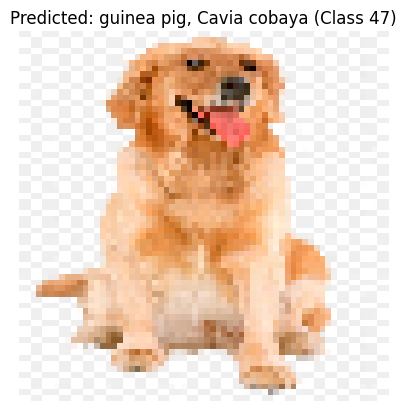

In [ ]:
predict_and_visualize('/content/1.png', model, class_indices, class_labels)

Get true labels and predicted labels for the validation set

In [ ]:
true_labels = []
predicted_labels = []

for images, labels in val_generator:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))
    if len(true_labels) >= val_generator.samples:
        break

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

Generate the classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=list(class_indices.keys()))
print(report)

              precision    recall  f1-score   support

   n01443537       0.95      0.82      0.88        50
   n01629819       0.88      0.74      0.80        50
   n01641577       0.54      0.56      0.55        50
   n01644900       0.67      0.24      0.35        50
   n01698640       0.65      0.52      0.58        50
   n01742172       0.37      0.52      0.43        50
   n01768244       0.64      0.76      0.70        50
   n01770393       0.78      0.36      0.49        50
   n01774384       0.53      0.84      0.65        50
   n01774750       0.94      0.34      0.50        50
   n01784675       0.65      0.64      0.65        50
   n01855672       0.67      0.68      0.67        50
   n01882714       0.84      0.74      0.79        50
   n01910747       0.85      0.78      0.81        50
   n01917289       0.58      0.86      0.69        50
   n01944390       0.69      0.54      0.61        50
   n01945685       0.70      0.46      0.55        50
   n01950731       0.77    

From the classification report, let’s assume identified classes with an F1-score lower than 0.70.

Assume we have true_labels and predicted_labels from previous steps:

In [ ]:
report_dict = classification_report(true_labels, predicted_labels, target_names=list(class_indices.keys()), output_dict=True)

Identify Poor Performing Classes:

In [ ]:
def get_poor_performing_classes(report_dict, threshold=0.7):
    low_accuracy_classes = []
    for class_name, metrics in report_dict.items():
        if class_name not in ["accuracy", "macro avg", "weighted avg"]:
            if metrics["f1-score"] < threshold:
                low_accuracy_classes.append(class_name)
    return low_accuracy_classes

# Define the threshold for F1-score
f1_threshold = 0.7

# Get the list of poor performing classes
low_accuracy_classes = get_poor_performing_classes(report_dict, f1_threshold)
print(f"Poor performing classes: {low_accuracy_classes}")


Poor performing classes: ['n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01917289', 'n01944390', 'n01945685', 'n01983481', 'n01984695', 'n02085620', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02415577', 'n02437312', 'n02480495', 'n02486410', 'n02504458', 'n02666196', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815834', 'n02823428', 'n02837789', 'n02841315', 'n02843684', 'n02883205', 'n02892201', 'n02906734', 'n02909870', 'n02927161', 'n02948072', 'n02950826', 'n02963159', 'n02977058', 'n02988304', 'n02999410', 'n03014705', 'n03042490', 'n03085013', 'n03089624',

Let's make an additional augmentation:

In [ ]:
additional_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_dir = '/content/tiny-imagenet-200/train'

for class_name in low_accuracy_classes:
    class_dir = os.path.join(train_dir, class_name, 'images')
    if os.path.exists(class_dir):
        for file_name in os.listdir(class_dir):
            full_file_name = os.path.join(class_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, os.path.join(train_dir, class_name))
        print(f"Moved files from {class_dir} to {os.path.join(train_dir, class_name)}")
    else:
        print(f"Directory {class_dir} does not exist.")


Moved files from /content/tiny-imagenet-200/train/n01641577/images to /content/tiny-imagenet-200/train/n01641577
Moved files from /content/tiny-imagenet-200/train/n01644900/images to /content/tiny-imagenet-200/train/n01644900
Moved files from /content/tiny-imagenet-200/train/n01698640/images to /content/tiny-imagenet-200/train/n01698640
Moved files from /content/tiny-imagenet-200/train/n01742172/images to /content/tiny-imagenet-200/train/n01742172
Moved files from /content/tiny-imagenet-200/train/n01768244/images to /content/tiny-imagenet-200/train/n01768244
Moved files from /content/tiny-imagenet-200/train/n01770393/images to /content/tiny-imagenet-200/train/n01770393
Moved files from /content/tiny-imagenet-200/train/n01774384/images to /content/tiny-imagenet-200/train/n01774384
Moved files from /content/tiny-imagenet-200/train/n01774750/images to /content/tiny-imagenet-200/train/n01774750
Moved files from /content/tiny-imagenet-200/train/n01784675/images to /content/tiny-imagenet-200

Creating an additional generator for training images only with classes with low accuracy:

In [ ]:
from keras.utils import Sequence

def create_class_specific_generator(generator, class_indices, classes, base_dirs):
    class_filenames = []
    class_labels = []
    for base_dir in base_dirs:
        for class_name in classes:
            class_index = class_indices[class_name]
            class_dir = os.path.join(base_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Directory {class_dir} does not exist.")
                continue
            class_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, fname)) and fname.lower().endswith(('.jpeg', '.jpg', '.png'))]
            if not class_files:
                print(f"No files found in directory {class_dir}.")
                continue
            class_filenames.extend(class_files)
            class_labels.extend([class_name] * len(class_files))
            print(f"Found {len(class_files)} files in directory {class_dir}.")

    print(f"Found {len(class_filenames)} images for augmentation.")

    if not class_filenames:
        print("No valid images found for augmentation.")
        return None

    # Adding dummy classes to equalize the number of classes
    all_class_names = list(class_indices.keys())
    for class_name in all_class_names:
        if class_name not in classes:
            dummy_image = class_filenames[0]  # Use first image as dummy
            class_filenames.append(dummy_image)
            class_labels.append(class_name)

    df = pd.DataFrame({'filename': class_filenames, 'class': class_labels})
    print(df.head())

    class_specific_generator = generator.flow_from_dataframe(
        dataframe=df,
        directory=None,
        x_col='filename',
        y_col='class',
        target_size=(64, 64),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    return class_specific_generator

Make sure train_dir and val_dir are defined correctly:

In [ ]:
train_dir = '/content/tiny-imagenet-200/train'
val_dir = '/content/tiny-imagenet-200/val'

Create new instances of generators after moving files:

In [ ]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


Creating a generator for classes with low accuracy:

In [ ]:
# Створення генератора для класів з низькою точністю
additional_datagen = ImageDataGenerator(rescale=1.0/255.0)
class_indices = {class_name: idx for idx, class_name in enumerate(os.listdir(train_dir))}
additional_generator = create_class_specific_generator(additional_datagen, class_indices, low_accuracy_classes, [train_dir, val_dir])

if additional_generator is not None:
    class CombinedGenerator(Sequence):
        def __init__(self, generator1, generator2):
            self.generator1 = generator1
            self.generator2 = generator2

        def __len__(self):
            return min(len(self.generator1), len(self.generator2))

        def __getitem__(self, index):
            x1, y1 = self.generator1[index]
            x2, y2 = self.generator2[index]
            x_combined = np.concatenate((x1, x2), axis=0)
            y_combined = np.concatenate((y1, y2), axis=0)
            return x_combined, y_combined

    # combine general and additional generators
    combined_generator = CombinedGenerator(train_generator, additional_generator)

    # train model with combiened generator
    history = model.fit(
        combined_generator,
        epochs=25,
        validation_data=val_generator,
        callbacks=[early_stopping, reduce_lr, lr_scheduler]
    )
else:
    print("Additional generator is None. Skipping training with augmented data.")


Found 500 files in directory /content/tiny-imagenet-200/train/n01641577.
Found 500 files in directory /content/tiny-imagenet-200/train/n01644900.
Found 500 files in directory /content/tiny-imagenet-200/train/n01698640.
Found 500 files in directory /content/tiny-imagenet-200/train/n01742172.
Found 500 files in directory /content/tiny-imagenet-200/train/n01768244.
Found 500 files in directory /content/tiny-imagenet-200/train/n01770393.
Found 500 files in directory /content/tiny-imagenet-200/train/n01774384.
Found 500 files in directory /content/tiny-imagenet-200/train/n01774750.
Found 500 files in directory /content/tiny-imagenet-200/train/n01784675.
Found 500 files in directory /content/tiny-imagenet-200/train/n01855672.
Found 500 files in directory /content/tiny-imagenet-200/train/n01917289.
Found 500 files in directory /content/tiny-imagenet-200/train/n01944390.
Found 500 files in directory /content/tiny-imagenet-200/train/n01945685.
Found 500 files in directory /content/tiny-imagenet

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2855/2855 ━━━━━━━━━━━━━━━━━━━━ 359s 105ms/step - accuracy: 0.7060 - loss: 1.3243 - val_accuracy: 0.7193 - val_loss: 1.2652 - learning_rate: 6.0653e-05
Epoch 2/25
2855/2855 ━━━━━━━━━━━━━━━━━━━━ 253s 81ms/step - accuracy: 0.8152 - loss: 0.8455 - val_accuracy: 0.7807 - val_loss: 0.9902 - learning_rate: 6.0653e-05
Epoch 3/25
2855/2855 ━━━━━━━━━━━━━━━━━━━━ 228s 80ms/step - accuracy: 0.8840 - loss: 0.5714 - val_accuracy: 0.8354 - val_loss: 0.7652 - learning_rate: 6.0653e-05
Epoch 4/25
2855/2855 ━━━━━━━━━━━━━━━━━━━━ 268s 82ms/step - accuracy: 0.9293 - loss: 0.3970 - val_accuracy: 0.8768 - val_loss: 0.6149 - learning_rate: 6.0653e-05
Epoch 5/25
2855/2855 ━━━━━━━━━━━━━━━━━━━━ 228s 80ms/step - accuracy: 0.9528 - loss: 0.3008 - val_accuracy: 0.9046 - val_loss: 0.5124 - learning_rate: 6.0653e-05
Epoch 6/25
2855/2855 ━━━━━━━━━━━━━━━━━━━━ 272s 83ms/step - accuracy: 0.9648 - loss: 0.2470 - val_accuracy: 0.9163 - val_loss: 0.4580 - learning_rate: 6.0653e-05
Epoch 7/25
2855/2855 ━━━━━━━━━━━━━━━━━━━━ 25

Evaluate the model

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {val_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.9489 - loss: 0.3542
Validation Accuracy: 0.9599000215530396


Plot training history:

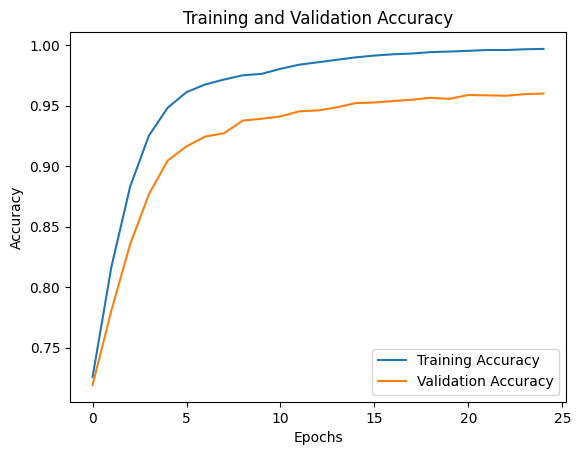

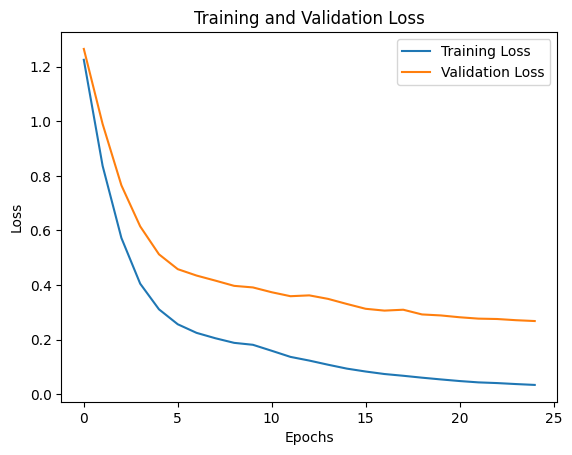

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
true_labels = []
predicted_labels = []

for images, labels in val_generator:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(np.argmax(labels, axis=1))
    if len(true_labels) >= val_generator.samples:
        break

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [ ]:
report = classification_report(true_labels, predicted_labels, target_names=list(class_indices.keys()))
print(report)

              precision    recall  f1-score   support

   n02999410       1.00      0.88      0.94        50
   n02666196       1.00      0.74      0.85        50
   n02793495       0.96      1.00      0.98        50
   n02977058       0.93      1.00      0.96        50
   n02906734       0.93      1.00      0.96        50
   n03838899       1.00      1.00      1.00        50
   n04417672       0.94      0.98      0.96        50
   n03763968       0.98      1.00      0.99        50
   n04487081       1.00      1.00      1.00        50
   n01774750       0.96      1.00      0.98        50
   n04399382       1.00      1.00      1.00        50
   n04149813       0.85      1.00      0.92        50
   n03891332       0.97      0.74      0.84        50
   n03089624       0.93      0.76      0.84        50
   n02094433       0.98      1.00      0.99        50
   n04008634       0.94      1.00      0.97        50
   n03393912       1.00      0.98      0.99        50
   n04074963       0.98    

We reached not bad result so we can save our trained model:

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/tiny_imagenet_efficientnet_b3_augmented.keras')

Let's try to predict with our model:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0.]]
Predicted class index: 23
Predicted synset ID: n03983396
Predicted class label: pop bottle, soda bottle


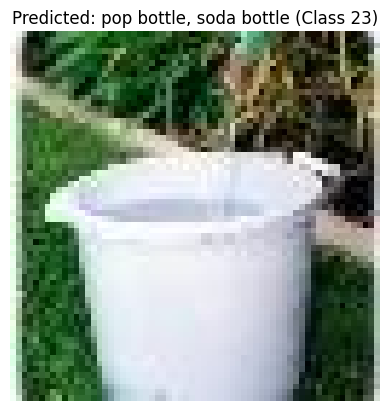

In [ ]:
predict_and_visualize('/content/tiny-imagenet-200/train/n02909870/n02909870_0.JPEG', model, class_indices, class_labels)